In [1]:
import pandas as pd
import numpy as np

In [2]:
import pymongo
from pymongo import MongoClient
client = MongoClient()
client.CPS.list_collection_names()
CPS = client.CPS

## 01. Retrieve data from mongodb

In [3]:
CPS.list_collection_names()

['PWSSWGT', 'PEEDUCA', 'PREMPNOT', 'PESEX', 'PWCMPWGT', 'PTDTRACE']

In [4]:
PEEDUCA = CPS.PEEDUCA.find_one()
PREMPNOT = CPS.PREMPNOT.find_one()
PESEX = CPS.PESEX.find_one()
PTDTRACE = CPS.PTDTRACE.find_one()
PWSSWGT = CPS.PWSSWGT.find_one()
PWCMPWGT = CPS.PWCMPWGT.find_one()

In [5]:
months = ['jan', 'feb', 'mar', 'apr']
df = pd.DataFrame(columns = ['month', 'weight_cf', 'weight', 'emp', 'sex', 'race', 'educa'])
for mon in months:
    temp_df = pd.DataFrame({
        'month': mon,
        'weight_cf': PWCMPWGT[mon],
        'weight': PWSSWGT[mon],
        'emp': PREMPNOT[mon],
        'sex': PESEX[mon],
        'race': PTDTRACE[mon],
        'educa': PEEDUCA[mon]
    })
    df = df.append(temp_df)

In [6]:
df["weight"] = pd.to_numeric(df["weight"])
df["weight_cf"] = pd.to_numeric(df["weight_cf"])
df = df.loc[df['weight_cf']>0]

## 02. Calculate non-seasonally adjusted unemployment rate

Here is how the weights should work: for example, if a person has a weight of 1,500 then the household is theoretically representing 1,500 other persons. 

In practice, the weights are scaled up by 10000.

I scale it down and convert units to thousands.

In [28]:
from time import strptime

df['month_num'] = [strptime(mon,'%b').tm_mon for mon in df['month']]

In [29]:
df.head(15)

,month,weight_cf,weight,emp,sex,race,educa,month_num
0,jan,17347552,17713809,4,1,2,38,1
1,jan,16756084,16864805,4,2,2,40,1
2,jan,21463402,20481802,4,1,1,40,1
3,jan,30966041,30137016,1,1,1,39,1
4,jan,17590812,17309391,1,2,1,43,1
5,jan,22252360,21931976,1,1,2,39,1
6,jan,20126642,19718618,1,2,2,39,1
8,jan,22147484,22450914,4,2,1,39,1
9,jan,28851877,33004731,4,2,2,39,1
10,jan,17379723,17492490,4,2,2,39,1


http://www.dlt.ri.gov/lmi/laus/us/usunadj.htm

These are the non-seasonally adjusted unemployment rates

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [61]:
def calc_unemployment(df):
    emp = df.loc[df['emp']==1]
    unemp = df.loc[df['emp']==2]
    tot_emp = emp['weight_cf'].groupby(emp["month_num"]).sum()
    tot_unemp = unemp['weight_cf'].groupby(unemp["month_num"]).sum()
    unemployment_rate = tot_unemp * 100 / (tot_emp + tot_unemp)
    return unemployment_rate

In [62]:
print(tot_emp/10000000) # this matches exactly the data from DLT

month
apr   133325.80812
feb   158017.40388
jan   156993.73231
mar   155167.19227
Name: weight_cf, dtype: float64


## 03. Unemployment rate per education level, race, sex
* these are all *NON-SEASONALLY-ADJUSTED* rates

### male and female unemployment rates

In [63]:
df['sex'].value_counts()

2    185635
1    170627
Name: sex, dtype: int64

In [64]:
m = df.loc[df['sex']==1]
f = df.loc[df['sex']==2]

In [67]:
unemployment_gender = pd.DataFrame({
    'm_unemp': calc_unemployment(m),
    'f_unemp': calc_unemployment(f), 
})

In [68]:
unemployment_gender

,m_unemp,f_unemp
month_num,,
1,4.20391,3.72473
2,4.09887,3.43667
3,4.79568,4.24119
4,13.29368,15.74342


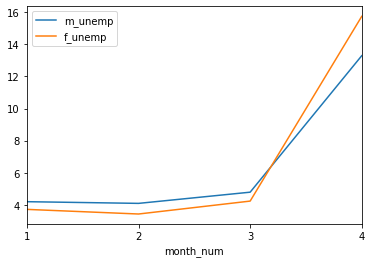

In [70]:
unemployment_gender.plot(xticks = unemployment_gender.index)

### unemployment rates by education

See data dictionary for code definitions

In [129]:
education_levels = df['educa'].value_counts()
education_levels = pd.DataFrame({"n": education_levels})
less_than_hs = education_levels.loc[education_levels.index <= 38].sum()[0]
less_than_hs

42276

In [135]:
education_levels = education_levels.loc[education_levels.index > 38]
education_levels = education_levels.append(pd.DataFrame({"n": less_than_hs}, index=[38]))
education_levels.sort_index(inplace = True)
education_levels

,n
37,42276
39,98417
40,60822
41,15742
42,20385
43,74769
44,32448
45,4899
46,6504


In [138]:
education_labels = ['LESS_THAN_HS', 'HS', 'COLLEGE_NO_DEG', 'ASSOCIATE_OCC', 'ASSOCIATE_ACA', 'BACHELORS', 'MASTERS', 'PROF', 'DOCTORATE']

In [157]:
education_unemp = {}
for i,l in zip(education_levels.index, education_labels):
    print(f"{i} - {l}")
    education_unemp[l] = df.loc[df['educa']==i]

37 - LESS_THAN_HS
39 - HS
40 - COLLEGE_NO_DEG
41 - ASSOCIATE_OCC
42 - ASSOCIATE_ACA
43 - BACHELORS
44 - MASTERS
45 - PROF
46 - DOCTORATE


In [159]:
education_unemp_df = pd.DataFrame()
for i,l in zip(education_levels.index, education_labels):
    education_unemp_df[l] = calc_unemployment(education_unemp[l])

In [160]:
education_unemp_df

,LESS_THAN_HS,HS,COLLEGE_NO_DEG,ASSOCIATE_OCC,ASSOCIATE_ACA,BACHELORS,MASTERS,PROF,DOCTORATE
month_num,,,,,,,,,
1,8.72474,5.50354,4.32339,2.57356,2.73815,2.41980,1.91978,1.20020,0.89768
2,9.68912,5.11733,4.01584,2.82239,2.93858,2.36763,1.71959,1.22257,1.32985
3,11.89713,5.84018,5.05841,3.91734,3.60366,2.60806,2.48463,1.92859,1.87475
4,27.35837,18.61755,18.65319,13.48940,14.28535,9.97865,6.72265,7.21983,3.23899


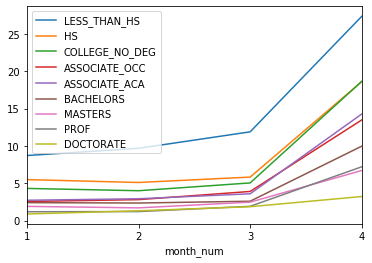

In [165]:
education_unemp_df.plot(xticks = education_unemp_df.index)